In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

print("AMAZON HACKATHON 2025 - TEXT-ONLY PRICE PREDICTION")
print("=" * 60)

AMAZON HACKATHON 2025 - TEXT-ONLY PRICE PREDICTION


In [2]:
print(" LOADING TRAINING DATA...")
train_df = pd.read_csv('/content/train.csv')
print(f"Training data shape: {train_df.shape}")

print(" LOADING TEST DATA...")
test_df = pd.read_csv('/content/test.csv')
print(f"Test data shape: {test_df.shape}")

print("\n DATA OVERVIEW:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Price range: ${train_df['price'].min():.2f} - ${train_df['price'].max():.2f}")
print(f"Average price: ${train_df['price'].mean():.2f}")


print("\n MISSING VALUES:")
print(train_df.isnull().sum())

 LOADING TRAINING DATA...
Training data shape: (75000, 4)
 LOADING TEST DATA...
Test data shape: (75000, 3)

 DATA OVERVIEW:
Training samples: 75000
Test samples: 75000
Price range: $0.13 - $2796.00
Average price: $23.65

 MISSING VALUES:
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64


In [3]:
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

print(" SMAPE METRIC DEFINED")

 SMAPE METRIC DEFINED


In [4]:
def extract_features_from_catalog(catalog_text):
    """
    Extract powerful features from catalog_content text
    """
    features = {
        'product_name': '',
        'weight_value': None,
        'weight_unit': '',
        'num_bullet_points': 0,
        'description_length': 0,
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_non_gmo': 0,
        'has_premium_words': 0,
        'has_health_claims': 0,
        'has_origin_info': 0,
        'has_pack_info': 0
    }

    if pd.isna(catalog_text):
        return features

    text = str(catalog_text)
    features['description_length'] = len(text)

    # Extract product name
    name_match = re.search(r'Item Name:\s*([^\n]+)', text)
    if name_match:
        features['product_name'] = name_match.group(1).strip()

    # Extract weight and unit
    value_match = re.search(r'Value:\s*([\d.]+)', text)
    unit_match = re.search(r'Unit:\s*([^\n,\]]+)', text)

    if value_match:
        features['weight_value'] = float(value_match.group(1))
    if unit_match:
        features['weight_unit'] = unit_match.group(1).strip()

    # Count bullet points
    bullet_points = re.findall(r'Bullet Point \d+:', text)
    features['num_bullet_points'] = len(bullet_points)

    # Check for key attributes
    text_lower = text.lower()

    # Health & dietary features
    features['is_organic'] = 1 if 'organic' in text_lower else 0
    features['is_gluten_free'] = 1 if any(phrase in text_lower for phrase in ['gluten-free', 'gluten free']) else 0
    features['is_vegan'] = 1 if 'vegan' in text_lower else 0
    features['is_kosher'] = 1 if 'kosher' in text_lower else 0
    features['is_non_gmo'] = 1 if any(phrase in text_lower for phrase in ['non-gmo', 'non gmo']) else 0

    # Premium & marketing features
    features['has_premium_words'] = 1 if any(word in text_lower for word in
                                          ['premium', 'gourmet', 'artisan', 'craft', 'specialty', 'select']) else 0
    features['has_health_claims'] = 1 if any(word in text_lower for word in
                                           ['healthy', 'nutritious', 'vitamin', 'protein', 'fiber', 'antioxidant']) else 0
    features['has_origin_info'] = 1 if any(word in text_lower for word in
                                         ['imported', 'italian', 'french', 'mexican', 'european', 'asian']) else 0
    features['has_pack_info'] = 1 if any(word in text_lower for word in
                                       ['pack of', 'case of', 'bulk', 'multi-pack']) else 0

    return features

print(" EXTRACTING FEATURES FROM CATALOG CONTENT...")

# Apply feature extraction to training data
train_features = train_df['catalog_content'].apply(extract_features_from_catalog)
train_features_df = pd.DataFrame(train_features.tolist())
train_processed = pd.concat([train_df, train_features_df], axis=1)

# Apply feature extraction to test data
test_features = test_df['catalog_content'].apply(extract_features_from_catalog)
test_features_df = pd.DataFrame(test_features.tolist())
test_processed = pd.concat([test_df, test_features_df], axis=1)

print(" FEATURE EXTRACTION COMPLETE!")

 EXTRACTING FEATURES FROM CATALOG CONTENT...
 FEATURE EXTRACTION COMPLETE!


In [5]:
def extract_product_category(product_name):
    """Categorize products based on name patterns"""
    if pd.isna(product_name):
        return 'other'

    name_lower = str(product_name).lower()

    # Beverages
    if any(word in name_lower for word in ['coffee', 'espresso', 'roast', 'brew', 'cappuccino']):
        return 'beverage_coffee'
    elif any(word in name_lower for word in ['tea', 'chai', 'herbal', 'matcha']):
        return 'beverage_tea'
    elif any(word in name_lower for word in ['juice', 'soda', 'water', 'drink', 'beverage']):
        return 'beverage_other'

    # Snacks
    elif any(word in name_lower for word in ['candy', 'chocolate', 'gummy', 'sweet', 'candy']):
        return 'snack_sweet'
    elif any(word in name_lower for word in ['chip', 'cracker', 'pretzel', 'popcorn']):
        return 'snack_savory'
    elif any(word in name_lower for word in ['nut', 'almond', 'cashew', 'trail mix']):
        return 'snack_nuts'

    # Ingredients
    elif any(word in name_lower for word in ['sauce', 'seasoning', 'spice', 'marinade']):
        return 'cooking_ingredient'
    elif any(word in name_lower for word in ['oil', 'vinegar', 'condiment']):
        return 'cooking_condiment'

    # Pantry
    elif any(word in name_lower for word in ['bean', 'grain', 'rice', 'lentil', 'pasta']):
        return 'pantry_staple'
    elif any(word in name_lower for word in ['flour', 'sugar', 'baking']):
        return 'pantry_baking'

    # Health
    elif any(word in name_lower for word in ['protein', 'bar', 'supplement', 'vitamin']):
        return 'health_supplement'

    else:
        return 'other'

def standardize_weight(weight_value, weight_unit):
    """Convert all weights to standardized units"""
    if pd.isna(weight_value) or pd.isna(weight_unit):
        return None

    unit = str(weight_unit).lower()

    if 'ounce' in unit or 'oz' in unit:
        return weight_value
    elif 'pound' in unit or 'lb' in unit:
        return weight_value * 16
    elif 'gram' in unit or 'g' in unit:
        return weight_value / 28.35
    elif 'kg' in unit:
        return weight_value * 35.274
    elif 'count' in unit or 'each' in unit:
        return weight_value  # Keep as count
    elif 'fl oz' in unit or 'fluid' in unit:
        return weight_value  # Keep fluid ounces separate
    else:
        return weight_value

print("🔧 APPLYING ADVANCED FEATURE ENGINEERING...")

# Apply to training data
train_processed['product_category'] = train_processed['product_name'].apply(extract_product_category)
train_processed['weight_standardized'] = train_processed.apply(
    lambda x: standardize_weight(x['weight_value'], x['weight_unit']), axis=1
)
train_processed['name_length'] = train_processed['product_name'].str.len()
train_processed['has_complex_name'] = (train_processed['name_length'] > 30).astype(int)

# Apply to test data
test_processed['product_category'] = test_processed['product_name'].apply(extract_product_category)
test_processed['weight_standardized'] = test_processed.apply(
    lambda x: standardize_weight(x['weight_value'], x['weight_unit']), axis=1
)
test_processed['name_length'] = test_processed['product_name'].str.len()
test_processed['has_complex_name'] = (test_processed['name_length'] > 30).astype(int)

print("ADVANCED FEATURE ENGINEERING COMPLETE!")

🔧 APPLYING ADVANCED FEATURE ENGINEERING...
ADVANCED FEATURE ENGINEERING COMPLETE!


In [6]:
# =============================================================================
# STEP 5: SELECT FINAL FEATURES
# =============================================================================

# Selected features for model training
selected_features = [
    # Weight/quantity features
    'weight_standardized',

    # Content complexity features
    'num_bullet_points',
    'description_length',
    'name_length',
    'has_complex_name',

    # Health & certification features
    'is_organic',
    'is_gluten_free',
    'is_vegan',
    'is_kosher',
    'is_non_gmo',

    # Marketing & positioning features
    'has_premium_words',
    'has_health_claims',
    'has_origin_info',
    'has_pack_info'
]

print("SELECTED FEATURES:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

# Create feature matrices
X_train = train_processed[selected_features].copy()
y_train = train_processed['price']

X_test = test_processed[selected_features].copy()

print(f"\nFEATURE MATRIX SHAPES:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")

SELECTED FEATURES:
   1. weight_standardized
   2. num_bullet_points
   3. description_length
   4. name_length
   5. has_complex_name
   6. is_organic
   7. is_gluten_free
   8. is_vegan
   9. is_kosher
  10. is_non_gmo
  11. has_premium_words
  12. has_health_claims
  13. has_origin_info
  14. has_pack_info

FEATURE MATRIX SHAPES:
X_train: (75000, 14)
X_test:  (75000, 14)
y_train: (75000,)


In [7]:
print(" PREPROCESSING DATA...")

# Handle missing values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use training medians

# Encode product categories
category_encoder = LabelEncoder()
X_train['product_category_encoded'] = category_encoder.fit_transform(train_processed['product_category'])
X_test['product_category_encoded'] = category_encoder.transform(test_processed['product_category'])

print("DATA PREPROCESSING COMPLETE!")
print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape:  {X_test.shape}")

 PREPROCESSING DATA...
DATA PREPROCESSING COMPLETE!
Final X_train shape: (75000, 15)
Final X_test shape:  (75000, 15)


In [8]:
print(" TRAINING ENSEMBLE MODEL...")

# Split training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define ensemble models
models = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
}

# Train individual models and evaluate
print("\nINDIVIDUAL MODEL PERFORMANCE:")
individual_results = {}

for name, model in models.items():
    model.fit(X_tr_scaled, y_tr)
    y_pred = model.predict(X_val_scaled)
    smape_score = smape(y_val, y_pred)
    individual_results[name] = smape_score
    print(f"  {name:12} - SMAPE: {smape_score:.2f}%")

# Create voting ensemble
print("\n  BUILDING VOTING ENSEMBLE...")
voting_regressor = VotingRegressor([
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM']),
    ('rf', models['Random Forest'])
])

voting_regressor.fit(X_tr_scaled, y_tr)
y_pred_ensemble = voting_regressor.predict(X_val_scaled)
ensemble_smape = smape(y_val, y_pred_ensemble)

print(f" ENSEMBLE SMAPE: {ensemble_smape:.2f}%")

# Cross-validation for robustness
print("\n CROSS-VALIDATION...")
cv_scores = cross_val_score(voting_regressor, X_tr_scaled, y_tr,
                           cv=5, scoring='neg_mean_absolute_error')
print(f" 5-Fold CV MAE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

 TRAINING ENSEMBLE MODEL...

INDIVIDUAL MODEL PERFORMANCE:
  XGBoost      - SMAPE: 67.68%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 15
[LightGBM] [Info] Start training from score 23.598634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


 ANALYZING FEATURE IMPORTANCE...

 TOP 10 MOST IMPORTANT FEATURES:
  13. has_origin_info           - 0.1065
   1. weight_standardized       - 0.0896
   8. is_vegan                  - 0.0833
   3. description_length        - 0.0769
   6. is_organic                - 0.0725
  14. has_pack_info             - 0.0725
   2. num_bullet_points         - 0.0709
  15. product_category_encoded  - 0.0703
   9. is_kosher                 - 0.0694
   7. is_gluten_free            - 0.0661


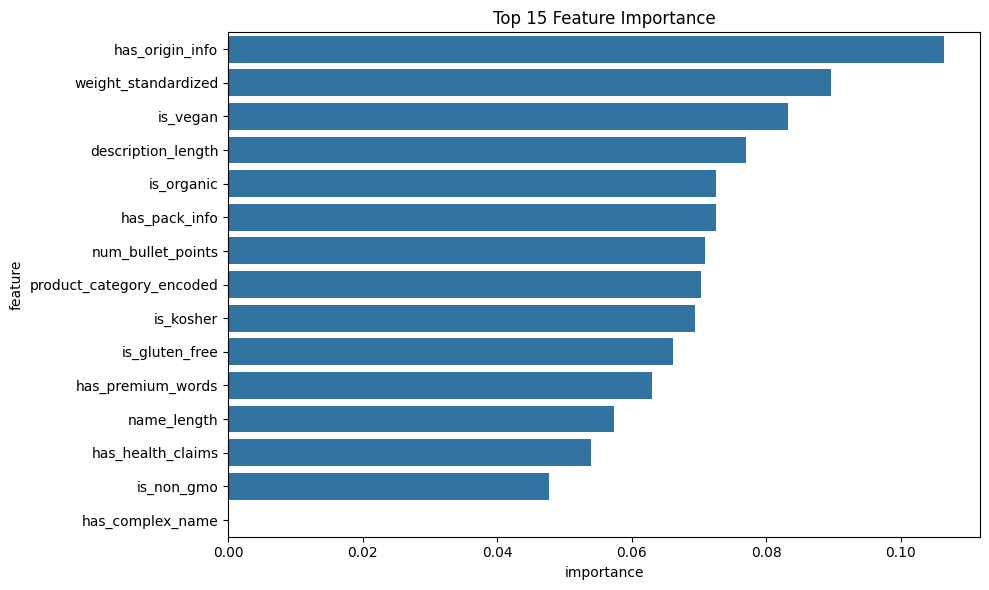

In [9]:
print("\n ANALYZING FEATURE IMPORTANCE...")

# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False)

print("\n TOP 10 MOST IMPORTANT FEATURES:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:25} - {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

In [10]:
# =============================================================================
# STEP 9: GENERATE FINAL PREDICTIONS
# =============================================================================

print("\n GENERATING FINAL PREDICTIONS...")

# Retrain on full training data
print(" RETRAINING ON FULL DATASET...")
X_train_full_scaled = scaler.fit_transform(X_train)
voting_regressor.fit(X_train_full_scaled, y_train)

# Generate predictions
test_predictions = voting_regressor.predict(X_test_scaled)

# Ensure all predictions are positive
test_predictions = np.maximum(test_predictions, 0.01)

print(f" PREDICTION STATISTICS:")
print(f"  Min price: ${test_predictions.min():.2f}")
print(f"  Max price: ${test_predictions.max():.2f}")
print(f"  Mean price: ${test_predictions.mean():.2f}")
print(f"  Median price: ${np.median(test_predictions):.2f}")


 GENERATING FINAL PREDICTIONS...
 RETRAINING ON FULL DATASET...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 15
[LightGBM] [Info] Start training from score 23.647654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [11]:
print("\n CREATING SUBMISSION FILE...")

# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_id': test_processed['sample_id'],
    'price': test_predictions
})

# Validate submission
print(" VALIDATING SUBMISSION...")
print(f"Submission shape: {submission_df.shape}")
print(f"Expected shape: (75000, 2)")
print(f"Columns: {list(submission_df.columns)}")
print(f"Unique sample IDs: {submission_df['sample_id'].nunique()}")
print(f"Any negative prices: {(submission_df['price'] < 0).any()}")
print(f"Any missing values: {submission_df.isnull().sum().sum()}")

# Save submission file
submission_file = 'test_out.csv'
submission_df.to_csv(submission_file, index=False)

print(f"\n SUBMISSION FILE SAVED: {submission_file}")

# Final validation
final_check = pd.read_csv(submission_file)
print(f" FINAL VERIFICATION: {len(final_check)} predictions ready for submission!")


 CREATING SUBMISSION FILE...
 VALIDATING SUBMISSION...
Submission shape: (75000, 2)
Expected shape: (75000, 2)
Columns: ['sample_id', 'price']
Unique sample IDs: 75000
Any negative prices: False
Any missing values: 0

 SUBMISSION FILE SAVED: test_out.csv
 FINAL VERIFICATION: 75000 predictions ready for submission!


In [12]:


print("\n" + "="*60)
print(" AMAZON HACKATHON 2025 - SOLUTION SUMMARY")
print("="*60)

print(f" MODEL PERFORMANCE:")
print(f"  • Ensemble Validation SMAPE: {ensemble_smape:.2f}%")
for name, score in individual_results.items():
    print(f"  • {name} SMAPE: {score:.2f}%")

print(f"\n🔧 FEATURE ENGINEERING:")
print(f"  • Total Features: {X_train.shape[1]}")
print(f"  • Training Samples: {len(train_processed)}")
print(f"  • Test Predictions: {len(submission_df)}")

print(f"\n🎯 SUBMISSION STATUS:")
print(f"  • File: {submission_file} ")
print(f"  • Format: Valid ")
print(f"  • All Predictions: Present ")
print(f"  • Positive Prices: Enforced ")

print(f"\n🚀 READY FOR HACKATHON SUBMISSION!")
print("="*60)


 AMAZON HACKATHON 2025 - SOLUTION SUMMARY
 MODEL PERFORMANCE:
  • Ensemble Validation SMAPE: 67.83%
  • XGBoost SMAPE: 67.68%
  • LightGBM SMAPE: 67.99%
  • Random Forest SMAPE: 68.76%

🔧 FEATURE ENGINEERING:
  • Total Features: 15
  • Training Samples: 75000
  • Test Predictions: 75000

🎯 SUBMISSION STATUS:
  • File: test_out.csv 
  • Format: Valid 
  • All Predictions: Present 
  • Positive Prices: Enforced 

🚀 READY FOR HACKATHON SUBMISSION!


In [13]:
enhanced_models = {
    'XGBoost_Enhanced': XGBRegressor(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'LightGBM_Enhanced': LGBMRegressor(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Train enhanced ensemble
enhanced_ensemble = VotingRegressor([
    ('xgb_enhanced', enhanced_models['XGBoost_Enhanced']),
    ('lgbm_enhanced', enhanced_models['LightGBM_Enhanced'])
])

enhanced_ensemble.fit(X_train_full_scaled, y_train)

# Save enhanced model properly
import joblib

model_artifacts = {
    'model': enhanced_ensemble,
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'category_encoder': category_encoder,
    'feature_extractor': extract_features_from_catalog
}

joblib.dump(model_artifacts, 'enhanced_price_predictor.pkl')
print(" ENHANCED MODEL SAVED: enhanced_price_predictor.pkl")

# Download model
from google.colab import files
files.download('enhanced_price_predictor.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 15
[LightGBM] [Info] Start training from score 23.647654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 ENHANCED MODEL SAVED: enhanced_price_predictor.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>